# Model

In [1]:
import json

# Load the configuration from the JSON file
with open('D:/BrainAge/HCCT/config.json', 'r') as f:
    config = json.load(f)

In [2]:
from model import ViTForClassfication

# Initialize the model with the loaded configuration
model = ViTForClassfication(config=config)

In [3]:
def count_parameters(model, trainable_only=True):
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())


In [4]:
total_params = count_parameters(model, trainable_only=False)
trainable = count_parameters(model, trainable_only=True)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable}")

Total parameters: 4715246
Trainable parameters: 4715246


In [5]:
import torch
extra_features= torch.randn(1,108)
x = torch.randn(1, 1, 91, 109, 91)
# output= model(x, extra_features)
output = model(x, output_attentions=False)

In [6]:
a,b = output

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
a

tensor([[-0.0334]], grad_fn=<AddmmBackward0>)

In [ ]:
len(b)

3

In [ ]:
type(b[0]), b[0].shape

(torch.Tensor, torch.Size([1, 8, 513, 513]))

In [ ]:
type(b[1]), b[1].shape

(torch.Tensor, torch.Size([1, 8, 513, 513]))

In [ ]:
type(b[2]), b[2].shape

(torch.Tensor, torch.Size([1, 8, 513, 513]))

# GradCam

In [7]:
for name, module in model.named_modules():
    print(name)


embedding
embedding.patch_embeddings
embedding.patch_embeddings.conv_1
embedding.patch_embeddings.conv_1.conv
embedding.patch_embeddings.conv_1.bn
embedding.patch_embeddings.conv_1.act
embedding.patch_embeddings.conv_1.maxpool
embedding.patch_embeddings.conv_2
embedding.patch_embeddings.conv_2.conv
embedding.patch_embeddings.conv_2.bn
embedding.patch_embeddings.conv_2.act
embedding.patch_embeddings.conv_2.maxpool
embedding.patch_embeddings.conv_3
embedding.patch_embeddings.conv_3.conv
embedding.patch_embeddings.conv_3.bn
embedding.patch_embeddings.conv_3.act
embedding.patch_embeddings.conv_3.maxpool
embedding.patch_embeddings.conv_4
embedding.patch_embeddings.conv_4.conv
embedding.patch_embeddings.conv_4.bn
embedding.patch_embeddings.conv_4.act
embedding.patch_embeddings.conv_4.maxpool
embedding.patch_embeddings.conv_5
embedding.patch_embeddings.conv_5.conv
embedding.patch_embeddings.conv_5.bn
embedding.patch_embeddings.conv_5.act
embedding.patch_embeddings.conv_5.maxpool
embedding.dr

In [8]:
# import nibabel as nib
# import numpy as np

# nii_path = r"D:\vestibularSchwannoma\AIIMsInfDataset\ImageNiftis\GKPFX2671\vs_gk_0000.nii.gz"
# img = nib.load(nii_path).get_fdata()
# DEVICE= 'cpu'

# # Normalize and convert to tensor [B, C, D, H, W]
# img = (img - np.mean(img)) / np.std(img)
# img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)
# img_tensor.requires_grad = True

In [9]:
img= torch.randn(91, 109, 91)  
img_tensor = torch.randn(1, 1, 91, 109, 91)
img_tensor.requires_grad = True

In [10]:
from captum.attr import LayerGradCam

# Choose final conv layer in DenseNet201 (last layer in last dense block)
target_layer = model.embedding.patch_embeddings.conv_5

gradcam = LayerGradCam(model, target_layer)

# Get Grad-CAM attribution for regression output
attribution = gradcam.attribute(img_tensor, target=0)
attr_map = attribution.squeeze().detach().cpu().numpy()

In [11]:
attribution.shape, attr_map.shape

(torch.Size([1, 1, 2, 3, 2]), (2, 3, 2))

In [12]:
# attribution[0][0]==attr_map

In [13]:
import torch.nn.functional as F

# attribution shape: [1, 1, D', H', W']
# Upsample to match input shape: [1, 1, 130, 130, 130] or whatever your input was
upsampled_attr = F.interpolate(
    attribution, size=img_tensor.shape[2:], mode='trilinear', align_corners=False
).squeeze().detach().cpu().numpy()

In [14]:
upsampled_attr.shape

(91, 109, 91)

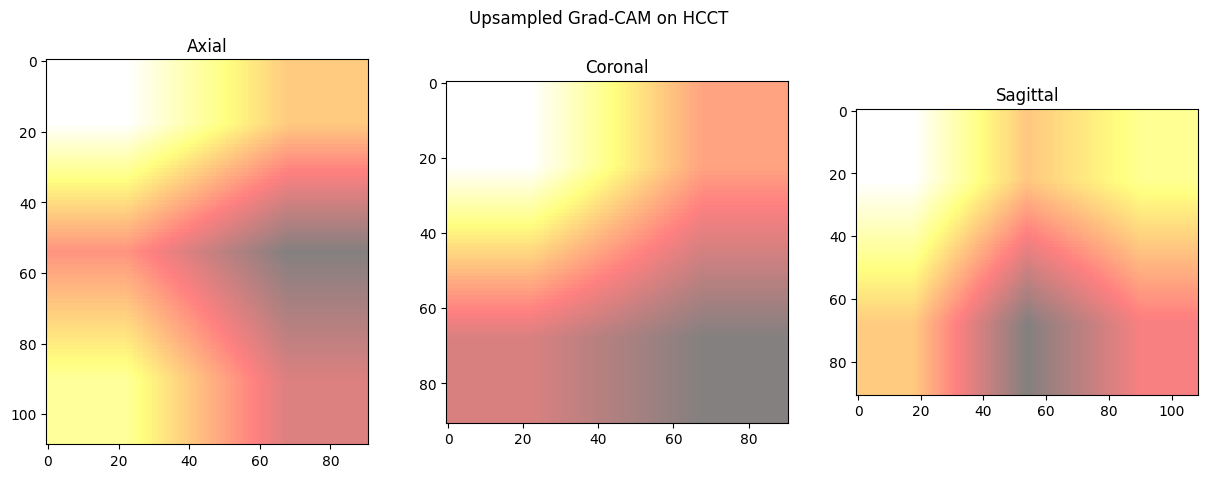

In [15]:
# only HeatMap

import matplotlib.pyplot as plt

# raw_img: already shape (D, H, W)
attr_map = upsampled_attr

# Get center slices
z, y, x = [s // 2 for s in attr_map.shape]

import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(attr_map[z], cmap='hot', alpha=0.5)
plt.title("Axial")

plt.subplot(1,3,2)
plt.imshow(attr_map[:, y, :], cmap='hot', alpha=0.5)
plt.title("Coronal")

plt.subplot(1,3,3)
plt.imshow(attr_map[:, :, x], cmap='hot', alpha=0.5)
plt.title("Sagittal")

plt.suptitle("Upsampled Grad-CAM on HCCT")
plt.show()


In [16]:
temp= upsampled_attr.squeeze()
temp.shape

(91, 109, 91)

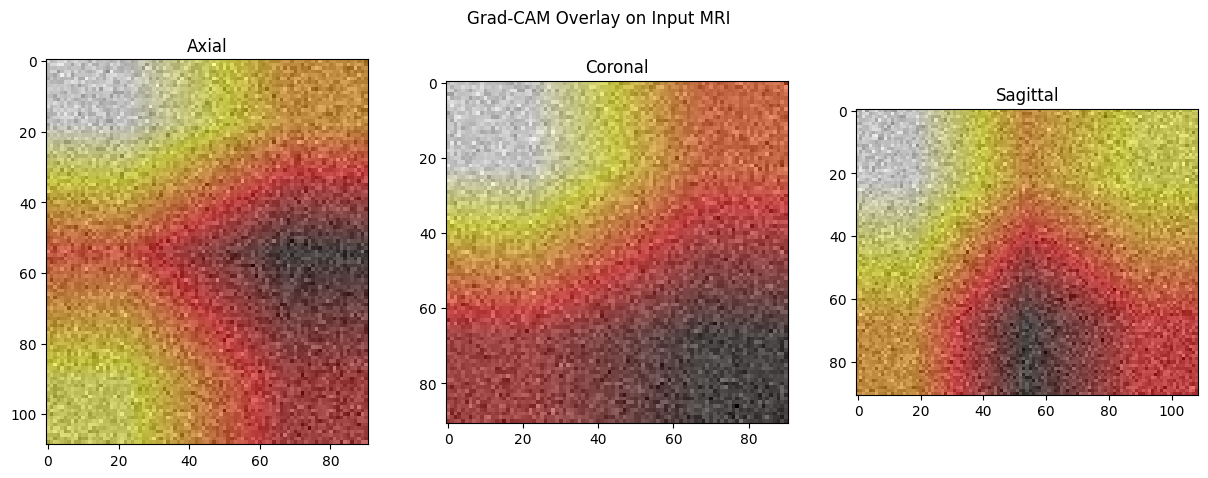

In [17]:
# overlayyed

import matplotlib.pyplot as plt

# Pick center slice for each axis
z, y, x = [s // 2 for s in img.shape]

plt.figure(figsize=(15, 5))

# Axial view
plt.subplot(1, 3, 1)
plt.imshow(img[z], cmap='gray')
plt.imshow(upsampled_attr[z], cmap='hot', alpha=0.5)
plt.title("Axial")

# Coronal view
plt.subplot(1, 3, 2)
plt.imshow(img[:, y, :], cmap='gray')
plt.imshow(upsampled_attr[:, y, :], cmap='hot', alpha=0.5)
plt.title("Coronal")

# Sagittal view
plt.subplot(1, 3, 3)
plt.imshow(img[:, :, x], cmap='gray')
plt.imshow(upsampled_attr[:, :, x], cmap='hot', alpha=0.5)
plt.title("Sagittal")

plt.suptitle("Grad-CAM Overlay on Input MRI")
plt.show()


# Attention Maps

In [18]:
x = torch.randn(1, 1, 91, 109, 91)
output = model(x, output_attentions=True)
a, b = output

Attention map corresponding to transformer block  1


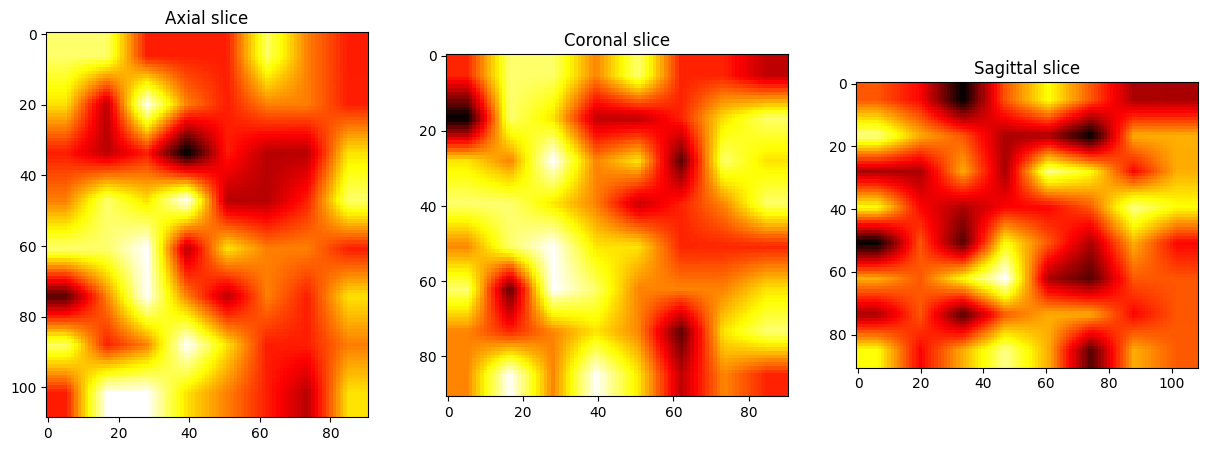

Attention map corresponding to transformer block  2


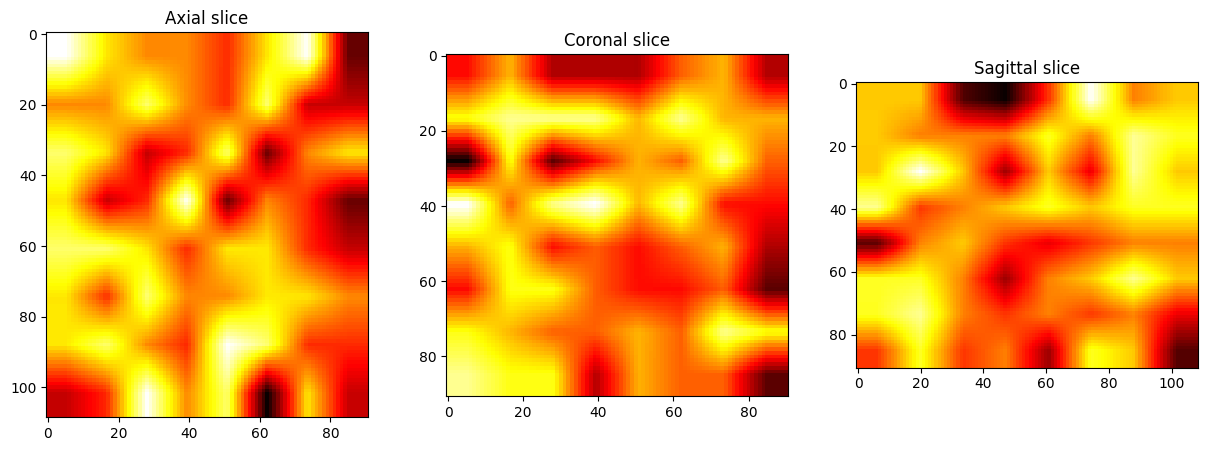

Attention map corresponding to transformer block  3


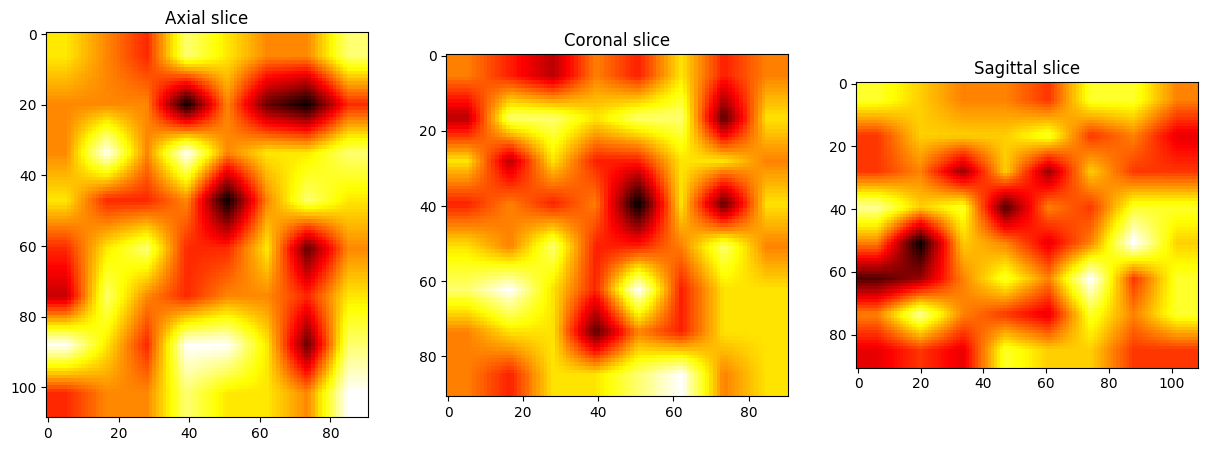

In [24]:
import matplotlib.pyplot as plt

for i in range(len(b)):

    attn_prob= b[i]

    # Step 1: Extract CLS token attention to all other tokens
    # Shape becomes [1, 8, 512]
    cls_attn = attn_prob[:, :, 0, 1:]

    # Step 2: Average over attention heads → shape: [1, 512]
    cls_attn_mean = cls_attn.mean(dim=1)

    # Step 3: Reshape to 3D grid (8 x 8 x 8)
    attn_3d = cls_attn_mean.view(1, 1, 8, 8, 8)  # [B, C, D, H, W]

    # Step 4: Interpolate to original shape [91, 109, 91]
    # Mode: 'trilinear' for 3D
    attn_upsampled = F.interpolate(attn_3d, size=(91, 109, 91), mode='trilinear', align_corners=False)

    # Step 5: Normalize the attention map for visualization
    attn_norm = (attn_upsampled - attn_upsampled.min()) / (attn_upsampled.max() - attn_upsampled.min())

    # Step 6: Convert to numpy for visualization or saving
    attn_map_np = attn_norm.squeeze().detach().numpy()  # shape: (91, 109, 91)

    # Optional: Visualize a middle slice in each plane
    print("Attention map corresponding to transformer block ", i+1)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(attn_map_np[45, :, :], cmap='hot')
    plt.title("Axial slice")

    plt.subplot(1, 3, 2)
    plt.imshow(attn_map_np[:, 54, :], cmap='hot')
    plt.title("Coronal slice")

    plt.subplot(1, 3, 3)
    plt.imshow(attn_map_np[:, :, 45], cmap='hot')
    plt.title("Sagittal slice")

    plt.show()


    # print(attn_prob.shape, cls_attn.shape, cls_attn_mean.shape)
    # break

# Attention Maps using captum

In [20]:
target_layer = model.encoder.blocks[2].attention.heads[7]

In [21]:
def reshape_transform(tensor):
    # Inspect `tensor.shape` here; often it is (batch, n_tokens, embed_dim)
    # Adapt the reshaping to match your attention head output
    # Below is a common pattern, but may need adjustment:
    batch_size, num_tokens, embed_dim = tensor.size()
    spatial_dim = int(num_tokens ** 0.5)
    return tensor.permute(0, 2, 1).reshape(batch_size, embed_dim, spatial_dim, spatial_dim)


In [22]:
from pytorch_grad_cam import GradCAM

cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)


ModuleNotFoundError: No module named 'pytorch_grad_cam'

In [ ]:
grayscale_cam = cam(input_tensor=x, targets=None)

In [81]:
# !pip install pytorch-gradcam

In [76]:
from captum.attr import LayerGradCam

# Choose final conv layer in DenseNet201 (last layer in last dense block)
target_layer = model.encoder.blocks[2].attention.heads[7]

gradcam = LayerGradCam(model, target_layer)

# Get Grad-CAM attribution for regression output
attribution = gradcam.attribute(img_tensor, target=0)
# attr_map = attribution.squeeze().detach().cpu().numpy()